#### Notebook with exclusive KLVI and inclusive KLVI- using Markovian score climbing ...

In [1]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
import autograd
import pickle
import pystan

In [2]:
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       perturbed_black_box_vi,
                       make_stan_log_density,
                       make_stan_log_density_grad,
                       adagrad_optimize, 
                     
                      )

from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         plot_dist_to_opt_param,
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

In [3]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat, adagrad_optimize, markov_score_climbing_cis

In [4]:
from viabel.vb_overdispersed import black_box_gapis,  adagrad_optimize_IS

In [5]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  matrix[N, 2] x;   // predictor matrix
  vector[N] y;      // outcome vector
  real<lower=1> df; // degrees of freedom
}
parameters {
  vector[2] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(df, x * beta, 1);  // likelihood
}"""

In [6]:
try:
    sm = pickle.load(open('robust_reg_model_inc.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_inc.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [7]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.75],[.75, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

In [8]:
data = dict(N=N, x=x, y=y, df=40)
fit = sm.sampling(data=data, iter=40000, thin=50, chains=4)

In [11]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
print('true mean =', true_mean)
print('true cov =', true_cov)

true mean = [-2.53131948  1.52584945]
true cov = [[ 0.44649544 -0.44256063]
 [-0.44256063  0.46005867]]


In [12]:
fit

Inference for Stan model: regression_model_da1de6f365ef6d14558a2a755c2fe849.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]  -2.53  9.1e-3   0.67  -3.85  -2.98  -2.53  -2.08  -1.23   5392    1.0
beta[2]   1.53  9.4e-3   0.68   0.21   1.07   1.51   1.98   2.89   5229    1.0
lp__    -20.31    0.01   1.04 -23.07 -20.71 -19.99 -19.58 -19.31   4882    1.0

Samples were drawn using NUTS at Fri Sep 11 14:12:13 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

#### True posterior marginals

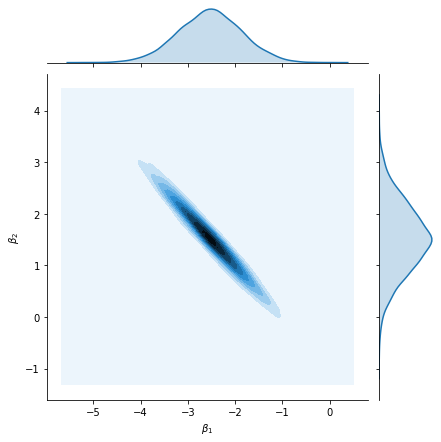

In [13]:

jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
#plt.show()

In [14]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-4,-1], ylim=[-.5,3.5])
mc_samples = 1000000  # number of Monte Carlo samples for estimating bounds and for PSIS

In [15]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(2, 40)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

klvi_var_param, klvi_param_history, _, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 77.855:  13%|█▎        | 672/5000 [00:03<00:24, 174.24it/s]


IndexError: tuple index out of range

### Plot with exclusive KLVI optimised params
#### Black shows true posterior, red shows approximation

In [16]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi1.pdf')

NameError: name 'klvi_var_param' is not defined

In [ ]:
#### Optimisation trace for the variational parameters- distance from optimal.

In [ ]:
plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

In [ ]:
check_approx_accuracy(mf_t_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

In [ ]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [ ]:
print(true_mean)
print(true_std)
print(klvi_var_param[:2])
print(np.exp(klvi_var_param[2:]))

In [26]:
k=2
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=10)
stan_log_density = make_stan_log_density(fit)
stan_log_density_grad= make_stan_log_density_grad(fit)

chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 10000)
incl_klvi_mf_objective_and_grad = markov_score_climbing_cis(mf_t_var_family, stan_log_density, 2000,2, nu=10)



In [28]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)*0.1
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 3000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
inc_klvi_var_param, inc_klvi_param_history, _,  inc_klvi_history, op_log_inklvi = \
    adagrad_optimize(n_iters, incl_klvi_mf_objective_and_grad, init_var_param, learning_rate=.011, has_log_norm=3,k=2)

Average Loss = -4.5315e-08: 100%|██████████| 3000/3000 [01:15<00:00, 39.96it/s]
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:191: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [29]:
print(inc_klvi_var_param)
print(true_mean)

[-2.52378663e+00  1.51601291e+00  1.88406702e-16  7.38334489e-19]
[-2.53131948  1.52584945]


In [30]:
print(np.linalg.norm(inc_klvi_var_param[:2]- true_mean,2))

0.012389564686723668


In [31]:
np.exp(inc_klvi_var_param[2:])

array([1., 1.])

#### Results with inclusive KL

In [32]:
check_approx_accuracy(mf_t_var_family, inc_klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.52378663  1.51601291]
stdevs = [1.11803399 1.11803399]

mean error             = 0.0124
stdev error            = 0.629
||cov error||_2^{1/2}  = 1.11
||true cov||_2^{1/2}   = 0.947


### Plot for inclusive KLVI optimised parameters

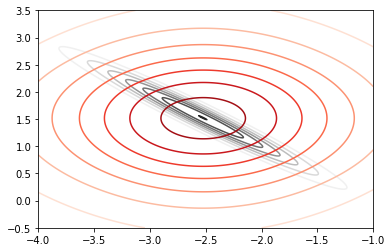

In [33]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, inc_klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi-inclusive.pdf')

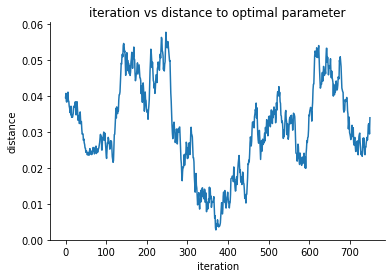

In [25]:
plot_dist_to_opt_param(inc_klvi_param_history, inc_klvi_var_param)